In [16]:
# Code for: <Add description here>
%load_ext autoreload
%autoreload 2
import cmcrameri.cm as cm  # Importing the cmcrameri colormaps

%run pf_data.py '../pflotran_model/hydrothermal.nc'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Primary minerals: ['Anorthite', 'Albite', 'Diopside', 'Hedenbergite', 'Forsterite', 'Fayalite']
Secondary minerals: ['Tremolite', 'Prehnite', 'Talc', 'Quartz', 'Saponite_Mg', 'Epidote', 'Zoisite', 'Chamosite', 'Clinochlore', 'Analcime', 'Anhydrite', 'Calcite', 'Annite']
Primary mineral groups: {'olivine': ['Forsterite', 'Fayalite'], 'clinopyroxenes': ['Diopside', 'Hedenbergite'], 'plagioclases': ['Anorthite', 'Albite']}
Secondary mineral groups: {'clays': ['Saponite_Mg', 'Chamosite', 'Clinochlore'], 'zeolites': ['Analcime'], 'amphiboles': ['Tremolite'], 'inosilicates': ['Prehnite'], 'talc': ['Talc'], 'epidotes': ['Epidote', 'Zoisite'], 'sulfates': ['Anhydrite'], 'carbonates': ['Calcite'], 'quartz': ['Quartz'], 'mica': ['Annite']}


In [17]:
# Code for: <Add description here>
import matplotlib.pyplot as plt
from itertools import cycle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes as is_ax

# Define a function for a custom color cycler
def custom_color_cycler():
   # Define a function for a custom Futurist-inspired color cycler
    colors = {
        'Magnesium': '#3498DB',   # Dark steel blue, dignified and cool
        'Sulfate': '#F1C40F',     # Dark, bold red with a lot of presence
        'Calcium': '#2ECC71',     # Dark jade green, distinct and elegant
        'Carbonate': '#E74C3C'    # Dark amethyst, standing apart with a creative, luxurious tone
    }
    
    # Create a color cycle
    return cycle([colors['Magnesium'], colors['Sulfate'], colors['Calcium'], colors['Carbonate']])


def plot_flux(ax, inset_ax, concentrations, data, plot_var,range_sets, legend_entries, crunchtope=False, linestyle='-'):
    """
    plot_flux: <Add description of function>
    """
    if crunchtope:
        dims = ['X', 'Y', 'Z']
        time=500
    else:
        dims = ['x', 'y', 'z']
        time=1000
    
    custom_cycler = custom_color_cycler()

    for conc_range, range_set, legend_entry in zip(concentrations, range_sets, legend_entries):
        # Processing data
        extracted_data = data[plot_var].sel(time=time).isel(file_number=slice(range_set[0], range_set[1] + 1)).mean(dim=dims)
        if plot_var == 'Anhydrite_VF' or plot_var == 'Anhydrite':
            # Scale up by volume
            extracted_data = data[plot_var].sel(time=time).isel(file_number=slice(range_set[0], range_set[1] + 1)).sum(dim=dims)
            volume = extracted_data.to_numpy() * 46.9 * 46.9 * 100 # m^3
            moles = volume_to_moles(volume, molar_volume)
            if crunchtope:
                flux = moles / time * 65000e3 / 100 / 1e12 * 32# tmol/yr
            else:
                flux = moles / time * 65000e3 / 100 / 1e12 # tmol/yr
            extracted_data = flux
        
        if legend_entry == 'HCO$\mathbf{_3^-}$':
            color = next(custom_cycler)
            inset_ax.plot(conc_range, extracted_data, label=legend_entry, color=color, linestyle=linestyle)
            ax.plot([], [], label=legend_entry, color=color, linestyle=linestyle)
        else:
            ax.plot(conc_range, extracted_data, label=legend_entry, color=next(custom_cycler), linestyle=linestyle)
        print(f'For {legend_entry}, the values are {extracted_data}')

In [18]:
def anhydrite_depth(data, crunchtope=False):
    if crunchtope:
        dims = ['X', 'Y', 'Z']
        time=500
        plot_var = 'Anhydrite'
        temperature = np.loadtxt('../crunchtope_model/on_axis_temp.txt')[0:100]
    else:
        dims = ['x', 'y', 'z']
        time=1000
        plot_var = 'Anhydrite_VF'
    # First, create a DataArray for depth, assuming `y` represents depth below seafloor
    depth = 1500 - data[dims[2]]

    mineral_data = data[plot_var].sel(time=time)

    if crunchtope:
        weighted_depth = mineral_data * xr.DataArray(temperature, dims='X')
    else:
        weighted_depth = data['Temperature'].sel(time=time) * mineral_data

    # Sum the weighted depth and the total mineral amount
    total_weighted_depth = weighted_depth.sum(dim=dims)
    total_mineral_amount = mineral_data.sum(dim=dims)

    # Calculate the average depth weighted by the amount of mineral
    average_depth = total_weighted_depth / total_mineral_amount

    # Extract the average value (as it may return a DataArray)
    average_depth_value = average_depth.to_numpy()

    return average_depth_value

In [19]:
# Code for: <Add description here>

def total_volume(data, mineral, crunchtope=False):
    """
    total_volume: <Add description of function>
    """
    if crunchtope:
        dims = ['X', 'Y', 'Z']
    else:
        dims = ['x', 'y', 'z']
    # Sum variables over all coordinates and select the final time 
    total_vf = data.sum(dim=dims).sel(time=500)[mineral].to_numpy()
    total_volume = total_vf * 46.9 * 46.9 * 100 # m^3 

    return total_volume

def volume_to_moles(volume, molar_volume):
    """
    volume_to_moles: <Add description of function>
    """
    moles = volume / molar_volume
    return moles

For SO$\mathbf{_4^{2-}}$, the values are <xarray.DataArray 'amphiboles_VF' (file_number: 5)>
array([0.00858771, 0.00821224, 0.00774712, 0.00724796, 0.00648218])
Coordinates:
    time     float64 1e+03
Dimensions without coordinates: file_number
For Ca$\mathbf{^{2+}}$, the values are <xarray.DataArray 'amphiboles_VF' (file_number: 4)>
array([0.00724796, 0.00781637, 0.00827165, 0.00868564])
Coordinates:
    time     float64 1e+03
Dimensions without coordinates: file_number
For Mg$\mathbf{^{2+}}$, the values are <xarray.DataArray 'amphiboles_VF' (file_number: 6)>
array([0.00600137, 0.0061741 , 0.00639758, 0.00668962, 0.00724796,
       0.00750828])
Coordinates:
    time     float64 1e+03
Dimensions without coordinates: file_number
For SO$\mathbf{_4^{2-}}$, the values are <xarray.DataArray 'clays_VF' (file_number: 5)>
array([0.00044439, 0.00043578, 0.0004302 , 0.00042469, 0.00041179])
Coordinates:
    time     float64 1e+03
Dimensions without coordinates: file_number
For Ca$\mathbf{^{2+}}$

/var/folders/86/d5n0l2wj5yn0p84q_4jzm_6r0000gn/T/ipykernel_49182/4043676366.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


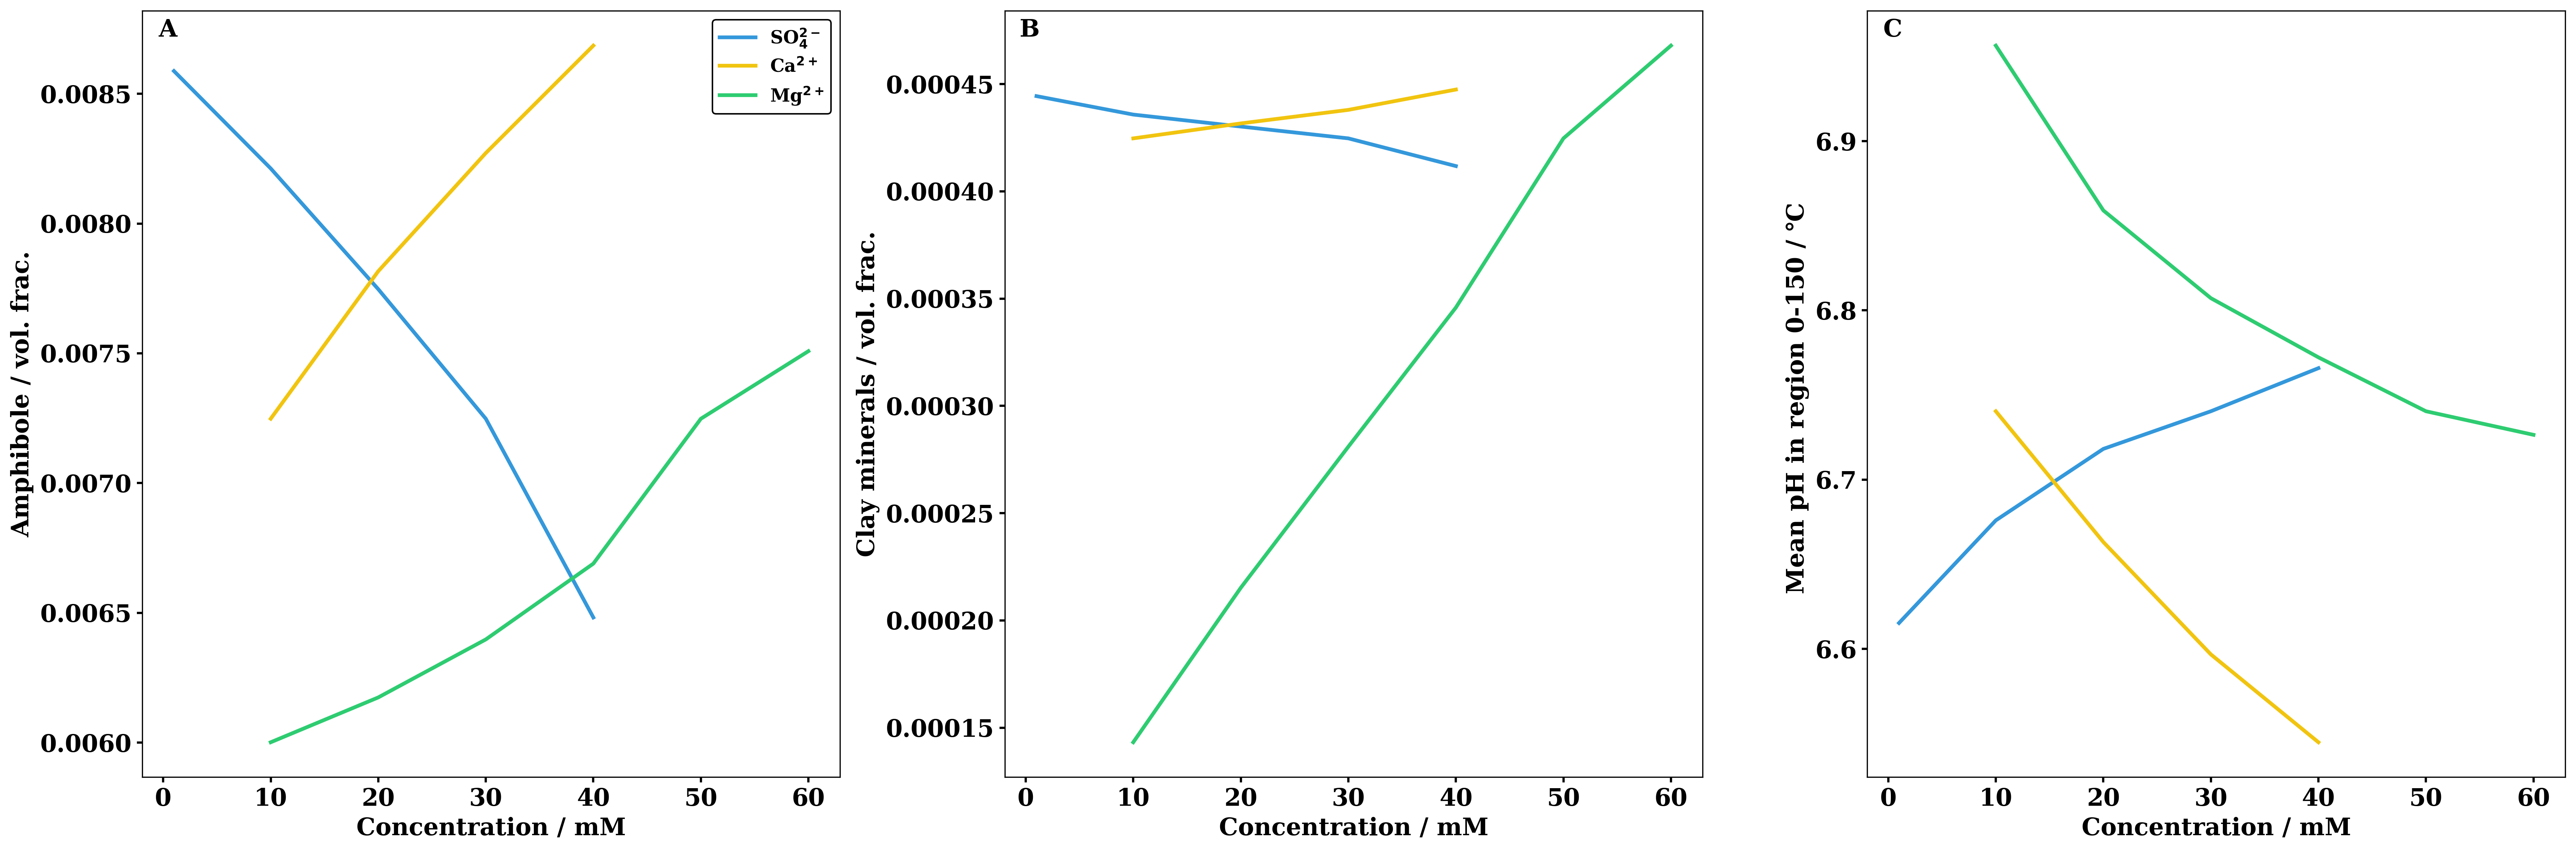

In [20]:
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('custom.mplstyle')
from cmcrameri import cm
import numpy as np
import copy
import string


# Create figure and axes
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
axes = axes.flatten()

fontsize = fig.bbox_inches.width * 1.2

# Example data and parameters
leg_entries = ['SO$\mathbf{_4^{2-}}$', 'Ca$\mathbf{^{2+}}$', 'Mg$\mathbf{^{2+}}$']
range_sets = [(10, 14), (6, 9), (0, 5)]
concentrations = [[1, 10, 20, 30, 40],  # SO4
                  [10, 20, 30, 40],  # Ca
                  [10, 20, 30, 40, 50, 60]]  # Mg

condition = (pf_data['Temperature'] >= 0) & (pf_data['Temperature'] <= 150)
# Plot flux (dummy function for example)
plot_var = 'amphiboles_VF'
plot_flux(axes[0], None, concentrations, pf_data, plot_var, range_sets, leg_entries)
plot_flux(axes[1], None, concentrations, pf_data, 'clays_VF', range_sets, leg_entries)
plot_flux(axes[2], None, concentrations, pf_data.where(condition), 'pH', range_sets, leg_entries)


axes[0].set_ylabel('Amphibole / vol. frac.')
axes[0].set_xlabel('Concentration / mM')
axes[0].legend(loc='upper right')
axes[1].set_ylabel('Clay minerals / vol. frac.')
axes[1].set_xlabel('Concentration / mM')
axes[2].set_ylabel('Mean pH in region 0-150 / ℃ ')
axes[2].set_xlabel('Concentration / mM')

subplot_labels = ['A', 'B', 'C'] 
# Add identifying letters to each subplot
for i, axis in enumerate(axes):
    axis.text(0.05, 0.99, subplot_labels[i], transform=axis.transAxes, 
              fontsize=16, fontweight='bold', va='top', ha='right')

# Show and save the figure
fig.tight_layout()
fig.show()
fig.savefig('output/figure_s3.png', dpi=300, transparent=True)

